In [14]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [15]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, num_classes=10):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        num_classes: количество случайных классов для выборки
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.num_classes = num_classes

        # Чтение всех классов
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]

        # Выбираем случайные 10 классов
        self.selected_classes = random.sample(self.class_names, self.num_classes)
        self.class_to_idx = {name: i for i, name in enumerate(self.selected_classes)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in self.selected_classes:
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls in self.selected_classes:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:  # Test
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "tiny-imagenet-200"

# Обучающий и валидационный датасеты
train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
val_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

# Загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

# Вывод статистики
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(train_dataset.selected_classes)}")


Train size: 5000
Val size: 500
Классов: 10


In [16]:
def print_cls_names(root_dir):
    print("Выбранные классы:")
    with open(os.path.join(root_dir, 'words.txt'), 'r') as f:
        words_strings = [line.strip() for line in f]
        for cls in train_dataset.selected_classes:
            for line in words_strings:
                if line.startswith(cls):
                    print(f"{cls}: {line}")
                    break
print_cls_names(root)

Выбранные классы:
n03444034: n03444034	go-kart
n07614500: n07614500	ice cream, icecream
n02802426: n02802426	basketball
n02788148: n02788148	bannister, banister, balustrade, balusters, handrail
n02988304: n02988304	CD player
n04456115: n04456115	torch
n02481823: n02481823	chimpanzee, chimp, Pan troglodytes
n02058221: n02058221	albatross, mollymawk
n07720875: n07720875	bell pepper
n03085013: n03085013	computer keyboard, keypad


In [17]:
def print_cls_name_from_code(root_dir,code_name):
    print("Название класса:")
    with open(os.path.join(root_dir, 'words.txt'), 'r') as f:
        words_strings = [line.strip() for line in f]
        for line in words_strings:
            if line.startswith(code_name):
                print(f"{line}")
                break

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import time

# timeout = 60  # Максимальное время ожидания в секундах
# start_time = time.time()

# while time.time() - start_time < timeout:
#     try:
#         images, labels = next(iter(train_loader))
#         break  
#     except StopIteration:
#         print("Ошибка в загрузке данных или итерации")
#         break
#     if time.time() - start_time > timeout:
#         print("Превышено время ожидания. Прерываю выполнение.")
#         break

# def denormalize(img_tensor):
#     """Вернём изображение из нормализованного диапазона в [0,1]"""
#     mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
#     std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
#     img = img_tensor.permute(1, 2, 0) * std + mean
#     return img.clamp(0, 1)

# images_vis = images.permute(0, 2, 3, 1)

# images_vis = torch.stack([denormalize(img) for img in images])

# plt.figure(figsize=(12, 6))
# for i in range(8):
#     plt.subplot(2, 4, i+1)
#     plt.imshow(images_vis[i])
#     plt.title(f"Class: {labels[i].item()}")
#     plt.axis('off')
# plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
# plt.tight_layout()
# plt.show()

# print(f"Размер батча: {images.shape}")
# print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
# print(f"Метки классов: {labels.tolist()}")
# print(f"Всего классов в датасете: {len(train_dataset.class_names)}")
# print(f"Примеры названий классов: {train_dataset.class_names[:5]}")

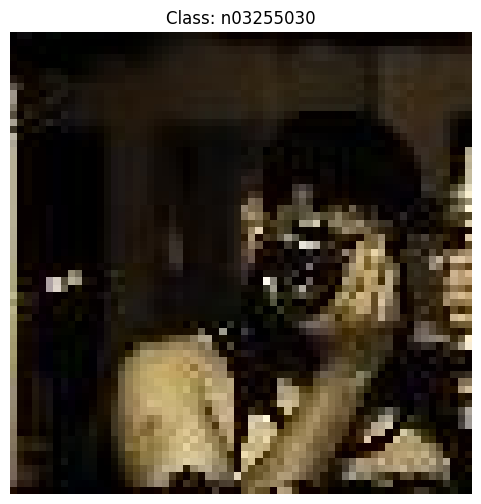

Размер изображения: torch.Size([1, 3, 64, 64])
Метка класса: 2
Название класса:
n03255030	dumbbell


In [18]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

# Преобразования
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Изменяем размер изображения
    transforms.ToTensor(),        # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализуем
])

# Инициализация датасета и DataLoader
root = "tiny-imagenet-200"
train_dataset = TinyImageNetDataset(root, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Установим batch_size=1

# Получаем одно изображение и метку
images, labels = next(iter(train_loader))

# Денормализация для отображения
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

# Денормализуем изображение
img_vis = denormalize(images[0])

# Визуализация одного изображения
plt.figure(figsize=(6, 6))
plt.imshow(img_vis.numpy())  # Переходим от тензора к NumPy для matplotlib
class_name = train_dataset.selected_classes[labels.item()]  # Получаем имя класса по индексу
plt.title(f"Class: {class_name}")  # Печатаем название класса
plt.axis('off')  # Убираем оси
plt.show()

print(f"Размер изображения: {images.shape}")
print(f"Метка класса: {labels.item()}")  # Выводим индекс метки
print_cls_name_from_code(root,class_name)  # Выводим название класса


In [19]:
from collections import Counter, defaultdict
import numpy as np

print(" Метод 1: Простая случайная стратификация")

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
all_samples = train_dataset.samples

print(f" Всего образцов: {len(all_samples)}")

random.seed(42)
all_samples_copy = all_samples.copy()
random.shuffle(all_samples_copy)

val_fraction = 0.2
split_idx = int(len(all_samples_copy) * (1 - val_fraction))
train_split_random = all_samples_copy[:split_idx]
val_split_random = all_samples_copy[split_idx:]

print(f" Случайное разделение:")
print(f"   Train: {len(train_split_random)} образцов")
print(f"   Val: {len(val_split_random)} образцов")

def analyze_class_distribution(samples, name):
    labels = [label for _, label in samples]
    class_counts = Counter(labels)
    print(f" {name} - распределение классов:")
    print(f"   Минимум: {min(class_counts.values())}")
    print(f"   Максимум: {max(class_counts.values())}")
    print(f"   Среднее: {np.mean(list(class_counts.values())):.1f}")
    print(f"   Стандартное отклонение: {np.std(list(class_counts.values())):.1f}")

analyze_class_distribution(train_split_random, "Случайное train")
analyze_class_distribution(val_split_random, "Случайное val")


 Метод 1: Простая случайная стратификация
 Всего образцов: 5000
 Случайное разделение:
   Train: 4000 образцов
   Val: 1000 образцов
 Случайное train - распределение классов:
   Минимум: 388
   Максимум: 418
   Среднее: 400.0
   Стандартное отклонение: 9.5
 Случайное val - распределение классов:
   Минимум: 82
   Максимум: 112
   Среднее: 100.0
   Стандартное отклонение: 9.5


In [20]:
# Заполните пропуски в BasicBlock
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection
    
    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
    

    def forward(self, x):
        idenity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Вторая свертка
        out = self.conv2(out)
        out = self.bn2(out) 

        if self.downsample is not None:
            idenity = self.downsample(x)

        out += idenity
        out = self.relu(out)

        return out

# basic_block = BasicBlock(64, 64, stride=2, downsample=nn.Sequential(
#     nn.Conv2d(64, 64, kernel_size=1, stride=2),
#     nn.BatchNorm2d(64)
# ))

# # Тестовый вход: 2 изображения размером 64x32x32
# test_input = torch.randn(2, 64, 32, 32)

# # Применяем блок
# output = basic_block(test_input)
# print(output.shape) 

In [21]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.in_channels = 64  # Инициализируем in_channels
        
        # Первый слой: Conv2d + BatchNorm + ReLU + MaxPool
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer1: 2x Basic Block с 64 каналами
        self.layer1 = self._make_layer(64, 2, stride=1)

        # Layer2: 2x Basic Block с 128 каналами
        self.layer2 = self._make_layer(128, 2, stride=2)

        # Layer3: 2x Basic Block с 256 каналами
        self.layer3 = self._make_layer(256, 2, stride=2)

        # Layer4: 2x Basic Block с 512 каналами
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Полносвязный слой для классификации (10 классов)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [37]:
# Вариант A: 32 -> 64 -> 128 -> 256
class ResNet18_A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(32, 2, stride=1)
        self.layer2 = self._make_layer(64, 2, stride=2)
        self.layer3 = self._make_layer(128, 2, stride=2)
        self.layer4 = self._make_layer(256, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Вариант B: 64 -> 128 -> 256 (без 4-го слоя)
class ResNet18_B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [23]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, acc


def validate_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    
    return avg_loss, acc


In [30]:
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, plotting=False):
    best_val_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Сохраняем метрики для графиков
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Логирование
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')  # Сохранение модели

    # Построение графиков
    if not plotting:
        plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses)

    print("Training complete.")

def plot_metrics(train_accuracies, val_accuracies, train_losses, val_losses):
    epochs = range(1, len(train_accuracies) + 1)
    
    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [31]:
def print_model_info(model):
    # Количество параметров
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

    # Архитектура модели
    print("\nModel Architecture:")
    print(model)



In [32]:
def plot_2_models_metrics(model_A, model_B):
    # Here, we assume that train_loss, val_loss, train_accuracy, and val_accuracy 
    # are stored from the training process in the respective model objects.
    plt.figure(figsize=(15, 10))

    # Plot Training Loss
    plt.subplot(2, 4, 1)
    plt.plot(model_A.train_loss, label="Model A Train Loss")
    plt.plot(model_B.train_loss, label="Model B Train Loss")
    plt.title("Training Loss")
    plt.legend()

    # Plot Validation Loss
    plt.subplot(2, 4, 2)
    plt.plot(model_A.val_loss, label="Model A Validation Loss")
    plt.plot(model_B.val_loss, label="Model B Validation Loss")
    plt.title("Validation Loss")
    plt.legend()

    # Plot Training Accuracy
    plt.subplot(2, 4, 3)
    plt.plot(model_A.train_accuracy, label="Model A Train Accuracy")
    plt.plot(model_B.train_accuracy, label="Model B Train Accuracy")
    plt.title("Training Accuracy")
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(2, 4, 4)
    plt.plot(model_A.val_accuracy, label="Model A Validation Accuracy")
    plt.plot(model_B.val_accuracy, label="Model B Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [33]:
import torch.optim as optim

def train_and_compare_models(train_loader, val_loader, num_classes=10, epochs=20):
    # Create both models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_A = ResNet18_A(num_classes=num_classes).to(device)
    model_B = ResNet18_B(num_classes=num_classes).to(device)
    
    # Define optimizers and loss functions
    optimizer_A = optim.Adam(model_A.parameters(), lr=0.001)
    optimizer_B = optim.Adam(model_B.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train models
    train_and_evaluate(model_A, train_loader, val_loader, optimizer_A, criterion, num_epochs=epochs, device=device, plotting=True)
    train_and_evaluate(model_B, train_loader, val_loader, optimizer_B, criterion, num_epochs=epochs, device=device, plotting=True)
    
    # Print model comparison results
    print(f"Model A - Number of parameters: {sum(p.numel() for p in model_A.parameters())}")
    print(f"Model B - Number of parameters: {sum(p.numel() for p in model_B.parameters())}")
    
    # Plot metrics for both models
    plot_2_models_metrics(model_A, model_B)
    
    return model_A, model_B


In [ ]:
#BASE RESNET18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель, оптимизатор и loss функция
model = ResNet18(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Обучение и валидация
train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device=device)

# Вывод информации о модели
print_model_info(model)

Epoch 1/20
Train Loss: 2.3679, Train Accuracy: 0.1320
Val Loss: 2.3557, Val Accuracy: 0.1140
Epoch 2/20
Train Loss: 2.1764, Train Accuracy: 0.2066
Val Loss: 2.5160, Val Accuracy: 0.0880
Epoch 3/20
Train Loss: 1.9764, Train Accuracy: 0.2932
Val Loss: 2.4631, Val Accuracy: 0.1020
Epoch 4/20
Train Loss: 1.8277, Train Accuracy: 0.3620
Val Loss: 2.5372, Val Accuracy: 0.1020
Epoch 5/20
Train Loss: 1.6642, Train Accuracy: 0.4128
Val Loss: 2.6683, Val Accuracy: 0.1080
Epoch 6/20
Train Loss: 1.4989, Train Accuracy: 0.4764
Val Loss: 2.7364, Val Accuracy: 0.1200
Epoch 7/20
Train Loss: 1.2851, Train Accuracy: 0.5560
Val Loss: 3.3308, Val Accuracy: 0.0980
Epoch 8/20
Train Loss: 1.0529, Train Accuracy: 0.6374
Val Loss: 3.2043, Val Accuracy: 0.1200
Epoch 9/20
Train Loss: 0.7955, Train Accuracy: 0.7312
Val Loss: 4.6015, Val Accuracy: 0.0880
Epoch 10/20
Train Loss: 0.5217, Train Accuracy: 0.8350
Val Loss: 5.0323, Val Accuracy: 0.1660
Epoch 11/20
Train Loss: 0.3581, Train Accuracy: 0.8802
Val Loss: 6.18

AttributeError: 'ResNet18_A' object has no attribute 'train_loss'

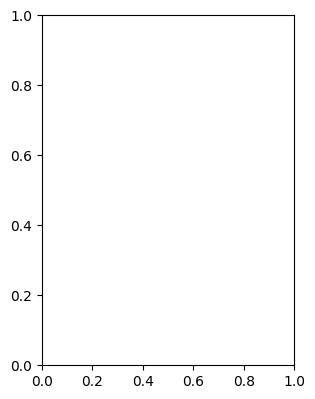

In [36]:
model_A, model_B = train_and_compare_models(train_loader, val_loader, num_classes=10, epochs=20)